In [0]:
import numpy as np
import cvxpy as cp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.special import expit
from sklearn import linear_model
from scipy import integrate
from scipy.stats import multivariate_normal

#Basic Settings

Suppose we are given $n$ input vectors $x_1, \ldots, x_n$ with standardized bivariate normal features
\begin{align*}
x_i \sim \mathcal{N}\left([0,0], [\begin{smallmatrix}1 & 0 \\ 0 & 1 \end{smallmatrix}] \right)  && i = 1,2, \ldots n
\end{align*}

For input $i$,  define an affine reward function pulling each arm (0 or 1)
$$
\delta_i \equiv \delta(x_i, y_i) = \begin{cases} \alpha_1 + x_i^T \beta_1 + \epsilon_{i,1} & \text{for } y_i = 1 \\
\alpha_0 + x_i^T \beta_0 + \epsilon_{i,0} & \text{for } y_i = 0\end{cases}
$$
where $\epsilon_{i, 0}, \epsilon_{i, 1}$ are intrinsic noises.

Further define a logistic policy determined by parameter $\gamma$
$$
\pi(x) = \mathbb{P}(y = 1 \mid x)= \frac{1}{1+\text{exp}(-x^T\gamma)}
$$
so that $\pi(y_i = 1 \mid x_i) \equiv \pi(x_i)$ and $\pi(y_i = 0 \mid x_i) \equiv 1 -  \pi(x_i)$

Then, we can obtain a logged data (set of tuples) according to the rules defined above
$$
D = \{(x_1, y_1, \delta_1, p_1), (x_2, y_2, \delta_2, p_2), \ldots , (x_n, y_n, \delta_n, p_n)\}
$$
where $y_i \in \{0,1\}$ and $p_i \equiv \pi(y_i \mid x_i)$. 

#Evaluating Utility

From the $\pi-$logged data , we may want to estimate the utility of a new policy $\bar\pi$
$$
U(\bar\pi) = \int\int_{x,y} \mathbb{P}(x)\bar\pi(y \mid x) \delta(x,y)
$$


1.   Monte Carlo Expectation (SAPE (sample average policy effect
) - optimal if $\delta$ is known)
$$
\hat U_{MC}(\bar \pi) = \frac{1}{n} \sum_{i=1}^n \left(\bar\pi(y_i = 1|x_i)\delta(x_i, 1) + \bar\pi(y_i = 0|x_i)\delta(x_i, 0)\right)
$$
2.   Inverse Propensity Scoring
$$
\hat U_{IPS}(\bar\pi) = \frac{1}{n} \sum_{i=1}^n \delta(x_i, y_i) \frac{\bar\pi(y_i \mid x_i)}{p_i}
$$
3.   Direct Method
$$
\hat U_{DM}(\bar \pi) = \frac{1}{n} \sum_{i=1}^n \left(\bar\pi(y_i = 1|x_i)\hat\delta_1(x_i)+ \bar\pi(y_i = 0|x_i)\hat \delta_0(x_i)\right)
$$
where $\hat\delta_1(\cdot)$, $\hat\delta_0(\cdot)$ are linear regression estimates of $\delta(x, 1)$, $\delta(x, 0)$, respectively. 
4.   Doubly Robust Estimator 
$$
\hat U_{DR}(\bar\pi) = \frac{1}{n} \sum_{i=1}^n \left[\frac{\bar\pi(y_i \mid x_i)}{p_i}\left(\delta(x_i, y_i) -\hat\delta(x_i, y_i)\right)\right] +\frac{1}{n} \sum_{i=1}^n \left(\bar\pi(y_i = 1|x_i)\hat\delta_1+ \bar\pi(y_i = 0|x_i)\hat \delta_0\right)
$$

5.   Kernel Optimal Matching
$$
\hat U_{KOM} (\bar \pi) = \frac{1}{n} \sum_{i=1}^n W^*_i \delta_i
$$
where
$$
W^*  = \underset{W \in \mathcal{W}}{\operatorname{argmin}} 
\text{CMSE}(\hat U_{W,f}, \pi) 
$$
and CMSE is the conditional mean square error of any weighted estimator from class $\mathcal{W}$. \\
We consider the simple case when $\delta_t$ has a Gaussian process prior with mean $f_t$ and covariance $\gamma_t \mathcal{k}_t$. Then, CMSE has a simple form (Kallus, 2018):
$$
\gamma_1 \mathfrak{B}_1^2(W, \pi_1, \|\cdot\|_{\mathcal{K}_1}) + \gamma_0 \mathfrak{B}_0^2(W, \pi_0, \|\cdot\|_{\mathcal{K}_0}) + \frac{1}{n^2} W^T \Sigma W
$$
Here, $\gamma, \Sigma$ are hyperparameters of Mahalanobis kernel and $\mathfrak{B}_t^2(W, \pi_t, \|\cdot\|_{\mathcal{K}_t})$ measures the relative worst-case discrepancy between $f$-moments of $t$-treated group (i.e., arm $t$) and the whole sample in the ball of RKHS . We can further simplify the objective via matrix expression. 
$$
(I_1W - \Pi_1)^TK_1(I_1W - \Pi_1) + (I_0W - \Pi_0)^TK_0(I_0W - \Pi_0) +  \frac{1}{n^2} W^T \Sigma W
$$
where $\Pi_t$ is the length-$n$ vector with $\pi(y_i=t\mid x_i)$ in $i^{\text{th}}$ entry and $I_t$
is the $n\times n$ diagonal matrix with $\mathbb{I}[y_i = t]$ in the $i^{\text{th}}$ diagonal entry. Notice that the problem is a QP and indeed solvable. 

In [0]:
# Code provided by Michele Santacatterina (santacatterina@cornell.edu)

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Product
from sklearn.gaussian_process.kernels import Sum
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

'''
Kernel Code for learning GP in KOM 
'''

def gpc_poly_prod(x,y,degree):
    kernel1 = (DotProduct(sigma_0=0.1) ** degree)
    kernel2 = (DotProduct(sigma_0=0.1) ** degree)
    kernel = Product(kernel1,kernel2)
    gpc = GaussianProcessClassifier(kernel=kernel).fit(x,y)
    return gpc


def gpc_poly(x,y,degree):
    kernel = (DotProduct() ** degree)
    gpc = GaussianProcessClassifier(kernel=kernel).fit(x,y)
    return gpc


def gp_test(x,y,degree1):
    k = (DotProduct() ** degree1)
    gpr =  GaussianProcessRegressor(kernel=k).fit(x,y)
    GramM = polynomial_kernel(x,degree=degree1,coef0=(gpr.kernel_.theta))
    GramM2 = gpr.kernel_(x)

    return {'gpr': gpr, 'GramMatrix': GramM, 'GramMatrix2': GramM2}



def gp(x,y,degree1,degree2,k1,k2,operator):
    if operator == "prod":
        if k1 == "poly" and k2 == "poly":
            k     =  ConstantKernel()*( (DotProduct() ** degree1)*(DotProduct() ** degree2) )  + WhiteKernel()
            #k     =  ( (DotProduct() ** degree1)*(DotProduct() ** degree2) )  + WhiteKernel()
            #k     =  ( (DotProduct(sigma_0=0.1) ** degree1)*(DotProduct(sigma_0=0.1) ** degree2) ) + WhiteKernel(noise_level=1.0)
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = np.exp((gpr.kernel_.theta[1]))*(polynomial_kernel(x,degree=degree1,coef0=np.exp(gpr.kernel_.theta[2]))*polynomial_kernel(x,degree=degree2,coef0=np.exp(gpr.kernel_.theta[3])))

        if k1 == "rbf" and k2 == "rbf":
            k     = ConstantKernel()*( (RBF())*(RBF()) ) + WhiteKernel()
            k     = ( (RBF())*(RBF()) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = rbf_kernel(x,gamma=gpr.kernel_.theta[2])*rbf_kernel(x,gamma=gpr.kernel_.theta[3])


        if k1 == "poly" and k2 == "rbf":
            k     = ConstantKernel()*( (DotProduct() ** degree1)*(RBF()) ) + WhiteKernel()
            #k     = ( (DotProduct() ** degree1)*(RBF()) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = polynomial_kernel(x,degree=degree1,coef0=gpr.kernel_.theta[2])*rbf_kernel(x,gamma=gpr.kernel_.theta[3])


        if k1 == "rbf" and k2 == "poly":
            k     = ConstantKernel()*( ( RBF() )*( DotProduct() ** degree2  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = rbf_kernel(x,gamma=gpr.kernel_.theta[2])*polynomial_kernel(x,degree=degree1,coef0=gpr.kernel_.theta[3])

        if k1 == "matern1.5" and k2 == "matern1.5":
            k     = ConstantKernel()*( ( Matern(nu=1.5) )*( Matern(nu=1.5)  ) ) + WhiteKernel()
            k     = ( ( Matern(nu=1.5) )*( Matern(nu=1.5)  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)

        if k1 == "matern2.5" and k2 == "matern2.5":
            k     = ConstantKernel()*( ( Matern(nu=2.5) )*( Matern(nu=2.5)  ) ) + WhiteKernel()
            k     = ( ( Matern(nu=2.5) )*( Matern(nu=2.5)  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)

        if k1 == "expsine2" and k2 == "expsine2":
            k     = ConstantKernel()*( ( ExpSineSquared() )*( ExpSineSquared()  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)  


        if k1 == "poly" and k2 == "matern1.5":
            k     = ConstantKernel()*( ( DotProduct() ** degree1 )*( Matern(nu=1.5)  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)  

        if k1 == "poly" and k2 == "matern2.5":
          k     = ConstantKernel()*( ( DotProduct() ** degree1 )*( Matern(nu=2.5)  ) ) + WhiteKernel()
          gpr   = GaussianProcessRegressor(kernel=k).fit(x,y) 

        if k1 == "matern1.5" and k2 == "poly":
            k     = ConstantKernel()*( ( Matern(nu=1.5) )*( DotProduct() ** degree2  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)  

        if k1 == "matern2.5" and k2 == "poly":
            k     = ConstantKernel()*( ( Matern(nu=2.5) )*( DotProduct() ** degree2  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)  



        if k1 == "poly" and k2 == "rbf":
            k     = ConstantKernel()*( ( DotProduct() ** degree1 )*( RBF()  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)  

        if k1 == "rbf" and k2 == "poly":
            k     = ConstantKernel()*( ( RBF() )*( DotProduct() ** degree2  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)   



    if operator == "sum":
        if k1 == "poly" and k2 == "poly":
            k     =  ConstantKernel()*( (DotProduct() ** degree1) + (DotProduct() ** degree2) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = np.exp((gpr.kernel_.theta[1]))*(polynomial_kernel(x,degree=degree1,coef0=np.exp(gpr.kernel_.theta[2]))*polynomial_kernel(x,degree=degree2,coef0=np.exp(gpr.kernel_.theta[3])))

        if k1 == "rbf" and k2 == "rbf":
            k     = ConstantKernel()*( (RBF()) + (RBF()) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = rbf_kernel(x,gamma=gpr.kernel_.theta[2])*rbf_kernel(x,gamma=gpr.kernel_.theta[3])


        if k1 == "poly" and k2 == "rbf":
            k     = ConstantKernel()*( (DotProduct() ** degree1) + (RBF()) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = polynomial_kernel(x,degree=degree1,coef0=gpr.kernel_.theta[2])*rbf_kernel(x,gamma=gpr.kernel_.theta[3])


        if k1 == "rbf" and k2 == "poly":
            k     = ConstantKernel()*( ( RBF() ) + ( DotProduct() ** degree2  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
            #GramM = rbf_kernel(x,gamma=gpr.kernel_.theta[2])*polynomial_kernel(x,degree=degree1,coef0=gpr.kernel_.theta[3])  


    if operator == "single":
        if k1 == "poly":
            k     = ConstantKernel()*( ( DotProduct()**degree1  ) ) + WhiteKernel()
            #k     = ( ( DotProduct(sigma_0=1)**degree1  ) ) + WhiteKernel()
            #k     = ConstantKernel()*( ( DotProduct(sigma_0=1)**degree1  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
        if k1 == "rbf":
            k     = ConstantKernel()*( ( RBF()  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)
        if k1 == "matern1.5":
            k     = ConstantKernel()*( ( Matern(nu=1.5)  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y)   
        if k1 == "matern2.5":
            k     = ConstantKernel()*( ( Matern(nu=2.5)  ) ) + WhiteKernel()
            gpr   = GaussianProcessRegressor(kernel=k).fit(x,y) 

    GramM = gpr.kernel_(x)


    return {'gpr': gpr, 'GramMatrix': GramM}

In [0]:
class LoggedDatum(object):
    """Generates Logged Data with Single Policy
    
       
        Parameters
        ----------
        n : int
            Number of samples 
        pol_param : array_like
            Policy parameter of that determines policy
        num_features : int, optional
            The number of features (covariates) of x (default is 2)
        policy : func, optional
            Policy function (default is logistic)            
        tol : float, optional
            Tolerance for numerical stability (default is 1e-12)
        
        Attributes
        ----------
        x : array_like
            Generated Covariates
        y : array_like
            Binary values corresponding to the policy
        d : array_like
            Observed Outcomes
        p : array_like
            Propensities pi(y|x)
    
    """
    x = None
    y = None
    d = None
    p = None
    
    def reward(alpha, beta):
        """
        Initialize two affine reward functions alpha + x^T beta
        Returns: affine reward function with parameter alpha, beta
        """
        return lambda x: alpha + np.dot(x, beta)
    
    global r0, r1
    r0 = reward(12, np.array([3,1]))
    r1 = reward(13, np.array([3,1]))
    
    global logistic
    def logistic(gamma):
        """
        Initialize logistic policy
        Returns: logistic function with parameter gamma
        """
        return lambda x: expit(np.dot(x, gamma))
    
    def __init__(self, n, pol_param = None, num_features = 2, policy = logistic, tol = 1e-12):
     
        self.n = n
        self.pol_param = pol_param
        self.num_features = num_features
        self.tol = tol
        self.policy = policy

        if pol_param is not None and len(pol_param) == num_features:
            self.x = np.random.multivariate_normal(np.zeros(num_features), np.eye(num_features), n)
            self.y = np.random.binomial(1, self.policy(pol_param)(self.x), n)
#             self.y = (np.random.uniform(size = n) < self.policy(self.pol_param)(self.x)) + 0
            self.d = self.set_helper()[0]
            self.p = self.set_helper()[1]

    # Use only when num_features = 2                
    def u_real(self, param_new):
        """
        Returns: PAPE of policy with new parameter
        """
        def integrand_helper(x, y, param_new): 
            return (r1([x,y]) * self.policy(param_new)([x,y]) + r0([x,y]) * \
                (1 - self.policy(param_new)([x,y]))) * \
                multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]]).pdf([x,y])
        
        return integrate.dblquad(integrand_helper, \
               -np.inf, np.inf, -np.inf, np.inf, args = (param_new,))[0]
    
    def set_helper(self):
        """
        Returns: delta array and propensity array of initialized data
        """
        d = np.zeros(self.n)
        
        a0_idx = np.where(self.y == 0)[0]
        a1_idx = np.where(self.y == 1)[0]

        # Feedback with N(0,1) noise
        d0 = r0(self.x[a0_idx]) + np.random.normal(0, 1, len(a0_idx))
        d1 = r1(self.x[a1_idx]) + np.random.normal(0, 1, len(a1_idx))
        d[a0_idx] = d0
        d[a1_idx] = d1
        
        return d, self.pi(self.x, self.y, self.pol_param)
        
    def pi(self, X, Y, param_new):
        """
        Returns: Propensities pi(Y | X) w.r.t input X, Y and a policy with
        param_new
        """
        p_new = self.policy(param_new)
        pi = np.zeros(len(X))

        a0_idx = np.where(Y == 0)[0]
        a1_idx = np.where(Y == 1)[0]

        # Propensity of logged data
        pi[a1_idx] = p_new(X)[a1_idx]
        pi[a0_idx] = (1 - p_new(X))[a0_idx]

        # Avoid division by zero
        pi[pi < self.tol] = self.tol
        pi[pi > 1 - self.tol] = 1 - self.tol

        return pi

    # Estimators    
    def u_mc(self, param_new):
        """
        Returns: Estimator 1(Sample Average Policy Effect) in the write-up
        """
        p_new = self.policy(param_new)
        return np.mean(r1(self.x) * p_new(self.x) + r0(self.x) * (1 - p_new(self.x)))
              
    def u_ips(self, param_new):
        """
        Returns: Estimator 2(Inverse Propensity Scoring) in the write-up
        """
        pi_bar = self.pi(self.x, self.y, param_new)
        return np.mean(self.d * pi_bar / self.p)
    
    def u_dmdr(self, param_new):
        """
        Returns: Estimators 3(Direct Method), 4(Doubly Robust) in the write-up
        """
        pi_bar = self.pi(self.x, self.y, param_new)
        p_new = self.policy(param_new)
        
        a0_idx = np.where(self.y == 0)[0]
        a1_idx = np.where(self.y == 1)[0]

        lm0 = linear_model.LinearRegression()
        lm0.fit(self.x[a0_idx], self.d[a0_idx])
        delta_0 = lm0.predict(self.x)

        lm1 = linear_model.LinearRegression()
        lm1.fit(self.x[a1_idx], self.d[a1_idx])
        delta_1 = lm1.predict(self.x)
        
        delta_hat = np.zeros(self.n)
        delta_hat[a0_idx] = delta_0[a0_idx]
        delta_hat[a1_idx] = delta_1[a1_idx] 
        
        u_dm = np.mean(delta_1 * p_new(self.x) + delta_0 * (1 - p_new(self.x)))
        u_dr = np.mean((self.d - delta_hat) * pi_bar / self.p) + u_dm
        return u_dm, u_dr
    
    def u_kom(self, param_new, degrees = [1,1], kernels = ["poly","poly"], operator = "prod", penal = 1):
        """
        Returns: Estimator 5(Kernal Optimal Matching) in the write-up
        """
        a0_idx = np.where(self.y == 0)[0]
        a1_idx = np.where(self.y == 1)[0]
        gp0 = gp(self.x[a0_idx], self.d[a0_idx], degrees[0], degrees[1], kernels[0], kernels[1], operator)
        gp1 = gp(self.x[a1_idx], self.d[a1_idx], degrees[0], degrees[1], kernels[0], kernels[1], operator)
        
        hyperparam0 = np.exp(gp0['gpr'].kernel_.theta)
        hyperparam1 = np.exp(gp1['gpr'].kernel_.theta)

        sigma0 = hyperparam0[0] ** 2
        sigma1 = hyperparam1[0] ** 2
        Sigma = np.diag(sigma0 * (1 - self.y) + sigma1 * self.y)
        
        Pi0 = self.p_matrix(self.x, param_new)[:,0]
        Pi1 = self.p_matrix(self.x, param_new)[:,1]

        I0 = np.diag(1 - self.y)
        I1 = np.diag(self.y)
        
        K0 = gp0['gpr'].kernel_(self.x)
        K1 = gp1['gpr'].kernel_(self.x)
        
        # Objectives in quadratic programming
        P = I0.T @ K0 @ I0 + I1.T @ K1 @ I1 + (1 / self.n ** 2) * penal * Sigma
        q = -2. * (Pi0.T @ K0 @ I0 + Pi1.T @ K1 @ I1)
        
        A = np.vstack((1. - self.y, self.y)) / self.n
        b = np.array([1., 1.])
        
        w = cp.Variable(self.n)
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, P) + q.T @ w),
                 [w >= self.tol,
                  A @ w == 0.5 * b])
        prob.solve()
        kom_weights = w.value

        return np.mean(kom_weights * self.d)

    # Matrices
    def d_matrix(self, X):
        """
        Returns: Matrix with columns 0 and 1 filled with rewards given X
        pulling arms 0 and 1, respectively.
        """
        return np.vstack((r0(X), r1(X))).T

    def p_matrix(self, X, param_new):
        """
        Returns: Matrix with columns 0 and 1 filled with pi(y=0|X), pi(y=1|X)
        given X, respectively
        """
        pol = self.policy(param_new)
        prob = pol(X)
        P = np.vstack((1 - prob, prob)).T
        P[P < self.tol] = self.tol
        P[P > 1 - self.tol] = 1 - self.tol
        return P

In [36]:
# Toy Example when param_new = [3,5]
D1 = LoggedDatum(1000, [3,5])

print("Population Average Policy Effect:", D1.u_real([3,5]))
print("Sample Average Policy Effect:", D1.u_mc([3,5]))
print("IPS Estimator:", D1.u_ips([3,5]))
print("Direct Method Estimator:", D1.u_dmdr([3,5])[0])
print("Doubly Robust Estimator:", D1.u_dmdr([3,5])[1])
print("Kernel Optimal Matching Estimator:", D1.u_kom([3,5]))

Population Average Policy Effect: 12.500000000000055
Sample Average Policy Effect: 12.534616753344324
IPS Estimator: 12.497806323536444
Direct Method Estimator: 12.473579282888895
Doubly Robust Estimator: 12.473579282888895
Kernel Optimal Matching Estimator: 12.472307815802823


In [0]:
def eval_estimators(N, param_0, param_new):
    """
    Returns: Estimators 1(SAPE), 2(IPS), 3(DM), 4(DR), 5(KOM) in the write-up
    """
    data = LoggedDatum(N, param_0)
    dmdr = data.u_dmdr(param_new)
    return data.u_mc(param_new), data.u_ips(param_new), dmdr[0], dmdr[1], data.u_kom(param_new)

In [0]:
def plot(param_0, param_new, nMin, nMax, nInc, nTrials):
    x = np.arange(nMin, nMax, nInc)
    ips_mean = []
    dm_mean = []
    dr_mean = []
    kom_mean = []
    ips_mse = []
    ips_var = []
    dm_var = []
    dm_mse = []
    dr_mse = []
    dr_var = []
    kom_mse = []
    kom_var = []
    
    for N in range(nMin, nMax, nInc):
        values = np.array([eval_estimators(N, param_0, param_new) for j in range(nTrials)])
        ips_mean.append(np.mean(values[:,0] - values[:,1]))
        ips_var.append(np.var(values[:,1]))
        ips_mse.append(np.mean(np.power(values[:,0] - values[:,1], 2)))

        dm_mean.append(np.mean(values[:,0] - values[:,2]))
        dm_var.append(np.var(values[:,2]))
        dm_mse.append(np.mean(np.power(values[:,0] - values[:,2], 2)))
        
        dr_mean.append(np.mean(values[:,0] - values[:,3]))
        dr_var.append(np.var(values[:,3]))
        dr_mse.append(np.mean(np.power(values[:,0] - values[:,3], 2)))
                      
        kom_mean.append(np.mean(values[:,0] - values[:,4]))
        kom_var.append(np.var(values[:,4]))
        kom_mse.append(np.mean(np.power(values[:,0] - values[:,4], 2)))    
            
    # log(RMSE) of U_IPS (cyan), U_DM (green), U_DR (yellow), U_KOM (blue)          
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, np.log(np.sqrt(ips_mse)), '-', color = 'c')
    line2, = plt.plot(x, np.log(np.sqrt(dm_mse)), '-', color = 'g')
    line3, = plt.plot(x, np.log(np.sqrt(dr_mse)), '-', color = 'y')
    line4, = plt.plot(x, np.log(np.sqrt(kom_mse)), '-', color = 'b')
    plt.legend((line1, line2, line3, line4), ('IPS', 'DM', 'DR', 'KOM'))
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('log(RMSE)')
    plt.show()
             
    # Bias of U_IPS (cyan), U_DM (green), U_DR (yellow), U_KOM (blue)          
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, ips_mean, '-', color = 'c')
    line2, = plt.plot(x, dm_mean, '-', color = 'g')
    line3, = plt.plot(x, dr_mean, '-', color = 'y')
    line4, = plt.plot(x, kom_mean, '-', color = 'b')
    plt.legend((line1, line2, line3, line4), ('IPS', 'DM', 'DR', 'KOM'))
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Bias')
    plt.show()
 
    # Variance of U_IPS (cyan), U_DM (green), U_DR (yellow), U_KOM (blue)        
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, ips_var, '-', color = 'c')
    line2, = plt.plot(x, dm_var, '-', color = 'g')
    line3, = plt.plot(x, dr_var, '-', color = 'y')
    line4, = plt.plot(x, kom_var, '-', color = 'b')
    plt.legend((line1, line2, line3, line4), ('IPS', 'DM', 'DR', 'KOM'))
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Variance')
    plt.show()
    
#     r = np.asarray(real_var)
#     i = np.asarray(ips_var)
#     d = np.asarray(dm_var)
#     plt.axhline(y = 0, color ='r', linestyle ='-')
#     plt.plot(x, i / r, '-', color = 'b')
#     plt.plot(x, d / r, '-', color = 'g')
#     plt.xlabel('Number of Samples (N)')
#     plt.ylabel('Estimates')
#     plt.show()

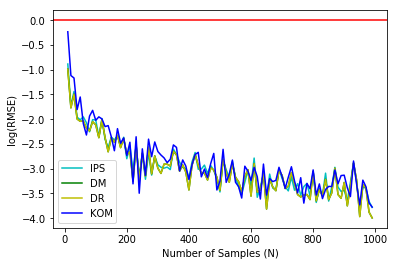

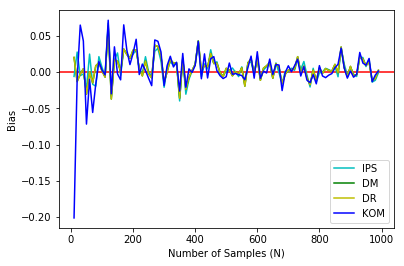

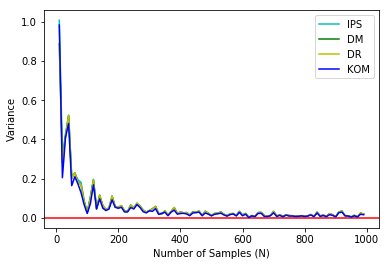

In [32]:
# Plot of Toy Example
plot([3,5], [3,5], 10, 1000, 10, 10)

# Evaluation from Multiple Loggers

We use similar setting as above. From the set $D = \cup_{i=1}^m D_i$ of $\pi_i-$logged data 
\begin{align*}
D^i = \{(x^i_1, y^i_1, \delta^i_1, p^i_1), (x^i_2, y^i_2, \delta^i_2, p^i_2), \ldots , (x^i_{n_i}, y^i_{n_i}, \delta^i_{n_i}, p^i_{n_i})\} && i = 1, 2, \ldots, m
\end{align*}
we may want to estimate the utility of a new policy $\bar\pi$
$$
U(\bar\pi) = \int\int_{x,y} \mathbb{P}(x)\bar\pi(y \mid x) \delta(x,y)
$$


1.   Monte Carlo Expectation (SAPE - optimal if $\delta$ is known)
$$
\hat U_{MC}(\bar \pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i} \left(\bar\pi(y^i_j = 1|x^i_j)\delta(x^i_j, 1) + \bar\pi(y^i_j = 0|x^i_j)\delta(x^i_j, 0)\right)
$$

### "Naive" Estimators (Same as in Single Logging Policy Above)
2.   Inverse Propensity Scoring
$$
\hat U_{IPS}(\bar\pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i}  \delta(x^i_j, y^i_j) \frac{\bar\pi(y^i_j \mid x^i_j)}{p^i_j}
$$
3.   Direct Method
$$
\hat U_{DM}(\bar \pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i} \left(\bar\pi(y^i_j = 1|x^i_j)\hat\delta_1(x^i_j) + \bar\pi(y^i_j = 0|x^i_j)\hat\delta_0(x^i_j)\right)
$$
where $\hat\delta_1(\cdot)$, $\hat\delta_0(\cdot)$ are linear regression estimates of $\delta(x, 1)$, $\delta(x, 0)$, respectively. 
4.   Doubly Robust Estimator 
$$
\hat U_{DR}(\bar\pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i}  \left[\frac{\bar\pi(y^i_j \mid x^i_j)}{p^i_j}\left(\delta(x^i_j, y^i_j) -\hat\delta(x^i_j, y^i_j)\right)\right] +\frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i}  \left(\bar\pi(y^i_j = 1|x^i_j)\hat\delta_1+ \bar\pi(y^i_j = 0|x^i_j)\hat \delta_0\right)
$$

5.   Kernel Optimal Matching
$$
\hat U_{KOM} (\bar \pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i}  W^{*i}_j\delta(x^i_j, y^i_j)
$$
where
$$
W^*  = \underset{W \in \mathcal{W}}{\operatorname{argmin}} 
\text{CMSE}(\hat U_{W,f}, \pi) 
$$
and CMSE is the conditional mean square error of any weighted estimator from class $\mathcal{W}$. \\
We consider the simple case when $\delta_t$ has a Gaussian process prior with mean $f_t$ and covariance $\gamma_t \mathcal{k}_t$. Then, CMSE has a simple form (Kallus, 2018):
$$
\gamma_1 \mathfrak{B}_1^2(W, \pi_1, \|\cdot\|_{\mathcal{K}_1}) + \gamma_0 \mathfrak{B}_0^2(W, \pi_0, \|\cdot\|_{\mathcal{K}_0}) + \frac{1}{n^2} W^T \Sigma W
$$
Here, $\gamma, \Sigma$ are hyperparameters of Mahalanobis kernel and $\mathfrak{B}_t^2(W, \pi_t, \|\cdot\|_{\mathcal{K}_t})$ measures the relative worst-case discrepancy between $f$-moments of $t$-treated group (i.e., arm $t$) and the whole sample in the ball of RKHS . We can further simplify the objective via matrix expression. 
$$
(I_1W - \Pi_1)^TK_1(I_1W - \Pi_1) + (I_0W - \Pi_0)^TK_0(I_0W - \Pi_0) +  \frac{1}{n^2} W^T \Sigma W
$$
where $\Pi_t$ is the length-$n$ vector with $\pi(y_i=t\mid x_i)$ in $i^{\text{th}}$ entry and $I_t$
is the $n\times n$ diagonal matrix with $\mathbb{I}[y_i = t]$ in the $i^{\text{th}}$ diagonal entry. Notice that the problem is a QP and indeed solvable. 

### Some Alternative Estimators (Agarwal et al. 2017)
6.  Balanced IPS Estimator
$$
\hat U_{Bal}(\bar \pi) = \frac{1}{n} \sum_{i=1}^m\sum_{j=1}^{n_i}  \delta(x^i_j, y^i_j) \frac{\bar\pi(y^i_j \mid x^i_j)}{\pi_{avg}(y^i_j \mid x^i_j)}
$$
where $\pi_{avg}(y \mid x) = \frac{\sum_{i=1}^m n_i \pi_i(y\mid x)}{n}$

7. Weighted IPS Estimator
$$
\hat U_{Weight}(\bar \pi) = \sum_{i=1}^m\lambda^*_i\sum_{j=1}^{n_i}  \delta(x^i_j, y^i_j) \frac{\bar\pi(y^i_j \mid x^i_j)}{p^i_j}
$$
where 
$$
\lambda^*_i = \frac{1}{\sigma^2_{\delta}(\bar\pi \| \pi_i) \sum_{j=1}^m \frac{n_j}{\sigma^2_{\delta}(\bar\pi \| \pi_j)}}
$$
and 
$\sigma^2_{\delta}(\bar\pi \| \pi)$ is the divergence between $\bar\pi$ and $\pi$ defined by
$$
\sigma^2_{\delta}(\bar\pi \| \pi) \equiv \text{Var}_{x,y} \left[\delta(x,y)\frac{\bar\pi(y \mid x)}{\pi(y \mid x)}\right]
$$

In [0]:
class LoggedData(LoggedDatum):
    """Generates Logged Data with Multiple Policies
       Subclass of LoggedDatum
 
        Parameters
        ----------
        *args : LoggedDatum Objects


        Attributes
        ----------
        pol_params : array_like
            Array of Policy parameters of input data
        num_logs: array_like
            Array of number of obeservations from each input data
        n : int
            The sum of all logged observations from input data
        D_matrix : array_like, optional
            List of delta matrices from each input data         
        P_matrix : array_like
            List of propensity matrices from each input data

         To use:
         >>> D1 = LoggedDatum(100, [1,1])
         >>> D2 = LoggedDatum(100, [2,2])
         >>> D = LoggedData(D1, D2)
         >>> D.pol_params
         [[1,1], [2,2]]
         
    """
        
    
    def __init__(self, *args):
        self.data = args
        self.num_logs = np.array(list(map(lambda dt: dt.n, args)))
        self.n = np.sum(self.num_logs)
        super(LoggedData, self).__init__(self.n)
        self.x = np.vstack(list(map(lambda dt: dt.x, args)))
        self.y = np.concatenate(list(map(lambda dt: dt.y, args)))
        self.pol_params = np.array(list(map(lambda dt: dt.pol_param, args)))
        self.d = np.concatenate(list(map(lambda dt: dt.d, args)))
        self.p = np.concatenate(list(map(lambda dt: dt.p, args)))
        self.D_matrix = np.array(list(map(lambda dt: dt.d_matrix(dt.x), args)))
        self.P_matrix = np.array(list(map(lambda dt: dt.p_matrix(dt.x, dt.pol_param), args)))
        
    def pi_bar(self, param_new):
        """
        Returns: Propensities pi(Y | X) of whole data w.r.t policy with param_new
        """
        return self.pi(self.x, self.y, param_new)
    
    def pi_avg(self, X, Y):
        """
        Returns: 
            Average of propensities according to the set of logged data
            (pi_avg defined in the write-up)
        """
        w = self.num_logs / self.n
        p = np.vstack(list(map(lambda dt: dt.pi(X, Y, dt.pol_param), self.data)))
        return np.average(p, axis = 0, weights = w)
    
    def u_bal(self, param_new):
        """
        Returns: Estimator 6(Balanced IPS) in the write-up
        """
        return np.mean(self.d * self.pi_bar(param_new) / self.pi_avg(self.x, self.y))

    def div_real(self, param_new):
        """
        Returns: Integrated values of divergence
        """
        U = self.u_real(param_new)
        
        def logistic_safe(gamma, eps = 1e-12):
            '''Avoids division by 0'''
            return lambda x: eps if expit(np.dot(x, gamma)) < eps else (1 - eps if expit(np.dot(x, gamma)) > 1 - eps else expit(np.dot(x, gamma)))
        def integrand_div(x, y, param_new, pol_param):
            return (np.power(r1([x,y]) * logistic_safe(param_new)([x,y]), 2) / logistic_safe(pol_param)([x,y]) \
                    + np.power(r0([x,y]) * (1 - logistic_safe(param_new)([x,y])), 2) / (1 - logistic_safe(pol_param)([x,y]))) \
                    * multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]]).pdf([x,y])
        def div_int(param_new, pol_param):
            return integrate.dblquad(integrand_div, -np.inf, np.inf, -np.inf, np.inf, args = (param_new, pol_param,))[0] - U ** 2
        
        div = []
        for pol_param in self.pol_params:
            div.append(div_int(param_new, pol_param))
            
        return np.array(div)    
    
    def u_weight_real(self, param_new):
        """
        Returns: Estimator 7(Weighted IPS) using integrated values of divergence
        """
        summand = np.sum(self.num_logs / self.div_emp(param_new))
        lmbda_list = 1 / (self.div_real(param_new) * summand)
        return np.sum(lmbda_list * [np.sum(arg.d * arg.pi(arg.x, arg.y, param_new) / arg.p) for arg in self.data])    
            
    def div_emp(self, param_new):
        """
        Returns: Divergence of new policy from empirical variance
        """
        return np.array([np.var(arg.d * arg.pi(arg.x, arg.y, param_new) / arg.p) for arg in self.data])
    
    def u_weight(self, param_new):
        """
        Returns: Estimator 7(Weighted IPS) using empirical values of divergence
        """
        summand = np.sum(self.num_logs / self.div_emp(param_new))
        lmbda_list = 1 / (self.div_emp(param_new) * summand)
        return np.sum(lmbda_list * [np.sum(arg.d * arg.pi(arg.x, arg.y, param_new) / arg.p) for arg in self.data])    
    
    
    # TODO: Variance (Needs Revision)
    def v_ips_emp(self,param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.div_emp(param_new))
   
    def v_ips(self, param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.div_real(param_new))
    
    def bal_emp(self, param_new):
        return  np.array([np.var(array) for array in self.D * self.pi_bar(param_new) / self.pi_avg()])
      
    def v_bal_emp(self, param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.bal_emp(param_new))
 
    def v_bal(self, param_new):
        summand1 = list(map(np.sum, np.power(self.u_helper(param_new) / self.pi_avg_matrix(), 2) * self.P_matrix))
        summand2 = list(map(np.sum, self.u_helper(param_new) / self.pi_avg_matrix() * self.P_matrix))
#         return 1 / (self.N ** 2) * np.sum(self.num_logs * (np.array(summand1) / self.num_logs - np.power(np.array(summand2)/self.num_logs, 2)))
        return 1 / (self.N ** 2) * np.sum(self.num_logs * (1 / self.N * np.array(summand1) - np.power(1 / self.N * np.array(summand2), 2)))

    def v_weight_emp(self, param_new):
        summand = np.sum(self.num_logs / self.div_emp(param_new))
        return 1 / summand
    
    def v_weight(self, param_new):
        summand = np.sum(self.num_logs / self.div_real(param_new))
        return 1 / summand

In [0]:
class LoggedDataM():
    ''' 
    =====
    Matrix Version of LoggedData
    =====
    '''
    def __init__(self, *args):
        self.data = args
        self.num_logs = np.array(list(map(lambda dt: dt.n, args)))
        self.N = np.sum(self.num_logs)
        self.X = list(map(lambda dt: dt.x, args))
        self.Y = list(map(lambda dt: dt.y, args))
        self.pol_params = np.array(list(map(lambda dt: dt.pol_param, args)))
        self.D = np.array(list(map(lambda dt: dt.d, args)))
        self.P = np.array(list(map(lambda dt: dt.p, args)))
        self.D_matrix = np.array(list(map(lambda dt: dt.d_matrix(dt.x), args)))
        self.P_matrix = np.array(list(map(lambda dt: dt.p_matrix(dt.x, dt.pol_param), args)))
        
    def pi_bar(self, param_new):
        return np.array(list(map(lambda dt: dt.pi(dt.x, dt.y, param_new), self.data)))

    def pi_bar_matrix(self, param_new):
        return np.array(list(map(lambda dt: dt.p_matrix(dt.x, param_new), self.data)))
    
    def u_helper(self, param_new):
        return self.D_matrix * self.pi_bar_matrix(param_new)
    
    def u_mc(self, param_new):    
        return 1 / self.N * np.sum(np.concatenate(self.u_helper(param_new)))

    def u_ips(self, param_new):
        return 1 / self.N * np.sum(np.concatenate(self.D * self.pi_bar(param_new) / self.P))
    
    def pi_avg(self):
        w = self.num_logs / np.sum(self.num_logs)
        P_avg = [list(map(lambda dt: dt.pi(self.X[i], self.Y[i], dt.pol_param), self.data)) for i in range(len(self.X))]
        return np.array(list(map(lambda p: np.average(p, axis = 0, weights = w), P_avg)))
    
    def pi_avg_matrix(self):
        w = self.num_logs / np.sum(self.num_logs)
        P_avg = [list(map(lambda dt: dt.p_matrix(self.X[i], dt.pol_param), self.data)) for i in range(len(self.X))]
        return np.array(list(map(lambda p: np.average(p, axis = 0, weights = w), P_avg)))
    
    def u_bal(self, param_new):
        return 1 / self.N * np.sum(np.concatenate(self.D * self.pi_bar(param_new) / self.pi_avg()))

    def div(self, param_new):
        div_list = list(map(np.sum, np.power(self.u_helper(param_new), 2) / self.P_matrix))
        return 1 / self.N * np.array(div_list) - self.u_mc(param_new) ** 2 

    def div_emp(self, param_new):
        return np.array([np.var(arg.d * arg.pi(arg.x, arg.y, param_new) / arg.p) for arg in self.data])
    
    def v_naive_emp(self,param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.div_emp(param_new))

    def v_weight_emp(self, param_new):
        summand = np.sum(self.num_logs / self.div_emp(param_new))
        return 1 / summand
    
    def bal_emp(self, param_new):
        return  np.array([np.var(array) for array in self.D * self.pi_bar(param_new) / self.pi_avg()])
      
    def v_bal_emp(self, param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.bal_emp(param_new))
    
    def u_weight(self, param_new):
        summand = 1 / self.v_weight(param_new)
        lmbda_list = 1 / (self.div(param_new) * summand)
        return np.sum(np.concatenate(lmbda_list * (self.D * self.pi_bar(param_new) / self.P)))
        
    # Variance
    def v_naive(self, param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.div(param_new))
    
    def v_bal(self, param_new):
        summand1 = list(map(np.sum, np.power(self.u_helper(param_new) / self.pi_avg_matrix(), 2) * self.P_matrix))
        summand2 = list(map(np.sum, self.u_helper(param_new) / self.pi_avg_matrix() * self.P_matrix))
#         return 1 / (self.N ** 2) * np.sum(self.num_logs * (np.array(summand1) / self.num_logs - np.power(np.array(summand2)/self.num_logs, 2)))
        return 1 / (self.N ** 2) * np.sum(self.num_logs * (1 / self.N * np.array(summand1) - np.power(1 / self.N * np.array(summand2), 2)))

    def v_weight(self, param_new):
        summand = np.sum(self.num_logs / self.div(param_new))
        return 1 / summand

In [49]:
# Toy Example with two logging policies
D1 = LoggedDatum(500, [2, 4])
D2 = LoggedDatum(500, [3, 5])
D = LoggedData(D1, D2)

print("Sample Average Policy Effect:", D.u_mc([3,5]))
print("IPS Estimator:", D.u_ips([3,5]))
print("Direct Method Estimator:", D.u_dmdr([3,5])[0])
print("Doubly Robust Estimator:", D.u_dmdr([3,5])[1])
print("Kernel Optimal Matching Estimator:", D.u_kom([3,5]))
print("Balanced IPS Estimator:", D.u_bal([3,5]))
print("Weighted IPS Estimator:", D.u_weight([3,5]))

Sample Average Policy Effect: 12.454591097404139
IPS Estimator: 12.52291918324434
Direct Method Estimator: 12.541107854240996
Doubly Robust Estimator: 12.540399828511974
Kernel Optimal Matching Estimator: 12.562917051734374
Balanced IPS Estimator: 12.54532321917926
Weighted IPS Estimator: 12.531185511671016


In [0]:
def eval_estimators2(N, param_1, param_2, param_new):
    """
    Returns: Estimators 1(SAPE), 2(IPS), 3(DM), 4(DR), 5(KOM), 6(Bal), 7(Weight) in the write-up
    """
    D1 = LoggedDatum(N, param_1)
    D1 = LoggedDatum(N, param_2)
    D = LoggedData(D1, D2)
    dmdr = D.u_dmdr(param_new)
    return D.u_mc(param_new), D.u_ips(param_new), dmdr[0], dmdr[1], D.u_kom(param_new), D.u_bal(param_new), D.u_weight(param_new)

In [0]:
def plot2(param_1, param_2, param_new, nMin, nMax, nInc, nTrials):
    x = np.arange(nMin, nMax, nInc)
    ips_mean = []
    dm_mean = []
    dr_mean = []
    kom_mean = []
    bal_mean = []
    weight_mean = []
    ips_mse = []
    ips_var = []
    dm_var = []
    dm_mse = []
    dr_mse = []
    dr_var = []
    kom_mse = []
    kom_var = []
    bal_mse = []
    bal_var = []
    weight_mse = []
    weight_var = []
    
    for N in range(nMin, nMax, nInc):
        values = np.array([eval_estimators2(N, param_1, param_2, param_new) for j in range(nTrials)])
        ips_mean.append(np.mean(values[:,0] - values[:,1]))
        ips_var.append(np.var(values[:,1]))
        ips_mse.append(np.mean(np.power(values[:,0] - values[:,1], 2)))

        dm_mean.append(np.mean(values[:,0] - values[:,2]))
        dm_var.append(np.var(values[:,2]))
        dm_mse.append(np.mean(np.power(values[:,0] - values[:,2], 2)))
        
        dr_mean.append(np.mean(values[:,0] - values[:,3]))
        dr_var.append(np.var(values[:,3]))
        dr_mse.append(np.mean(np.power(values[:,0] - values[:,3], 2)))
        
        kom_mean.append(np.mean(values[:,0] - values[:,4]))
        kom_var.append(np.var(values[:,4]))
        kom_mse.append(np.mean(np.power(values[:,0] - values[:,4], 2)))
        
        bal_mean.append(np.mean(values[:,0] - values[:,5]))
        bal_var.append(np.var(values[:,5]))
        bal_mse.append(np.mean(np.power(values[:,0] - values[:,5], 2)))
        
        weight_mean.append(np.mean(values[:,0] - values[:,6]))
        weight_var.append(np.var(values[:,6]))
        weight_mse.append(np.mean(np.power(values[:,0] - values[:,6], 2)))
        
                 
    # log(RMSE) of U_IPS (cyan), U_DM (green), U_DR (yellow), U_kom(blue), U_bal (magenta), U_weight (black) 
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, np.log(np.sqrt(ips_mse)), '-', color = 'c')
    line2, = plt.plot(x, np.log(np.sqrt(dm_mse)), '-', color = 'g')
    line3, = plt.plot(x, np.log(np.sqrt(dr_mse)), '-', color = 'y')
    line4, = plt.plot(x, np.log(np.sqrt(dr_mse)), '-', color = 'b')
    line5, = plt.plot(x, np.log(np.sqrt(bal_mse)), '-', color = 'm')
    line6, = plt.plot(x, np.log(np.sqrt(weight_mse)), '-', color = 'k')
    plt.legend((line1, line2, line3, line4, line5, line6), ('IPS', 'DM', 'DR', 'KOM', 'BAL', 'WEIGHT'))
    plt.xlabel('log(RMSE)')
    plt.ylabel('Estimates')
    plt.show()
             
    # Bias of U_IPS (cyan), U_DM (green), U_DR (yellow), U_kom(blue), U_bal (magenta), U_weight (black)    
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, ips_mean, '-', color = 'c')
    line2, = plt.plot(x, dm_mean, '-', color = 'g')
    line3, = plt.plot(x, dr_mean, '-', color = 'y')
    line4, = plt.plot(x, kom_mean, '-', color = 'b')
    line5, = plt.plot(x, bal_mean, '-', color = 'm')
    line6, = plt.plot(x, weight_mean, '-', color = 'k')
    plt.legend((line1, line2, line3, line4, line5, line6), ('IPS', 'DM', 'DR', 'KOM', 'BAL', 'WEIGHT'))
    plt.xlabel('Bias')
    plt.ylabel('Estimates')
    plt.show()
 
    # Variance of U_IPS (cyan), U_DM (green), U_DR (yellow), U_kom(blue), U_bal (magenta), U_weight (black)    
    plt.axhline(y = 0, color ='r', linestyle ='-')
    line1, = plt.plot(x, ips_var, '-', color = 'c')
    line2, = plt.plot(x, dm_var, '-', color = 'g')
    line3, = plt.plot(x, dr_var, '-', color = 'y')
    line4, = plt.plot(x, dr_var, '-', color = 'b')
    line5, = plt.plot(x, bal_var, '-', color = 'm')
    line6, = plt.plot(x, weight_var, '-', color = 'k')
    plt.legend((line1, line2, line3, line4, line5, line6), ('IPS', 'DM', 'DR', 'KOM', 'BAL', 'WEIGHT'))
    plt.xlabel('Variance')
    plt.ylabel('Estimates')
    plt.show()
    
#     r = np.asarray(real_var)
#     i = np.asarray(ips_var)
#     d = np.asarray(dm_var)
#     plt.axhline(y = 0, color ='r', linestyle ='-')
#     plt.plot(x, i / r, '-', color = 'b')
#     plt.plot(x, d / r, '-', color = 'g')
#     plt.xlabel('Number of Samples (N)')
#     plt.ylabel('Estimates')
#     plt.show()

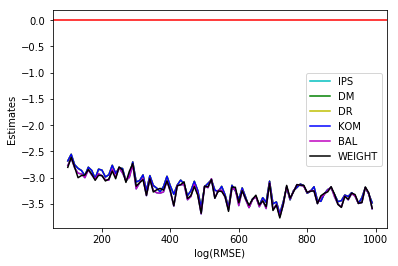

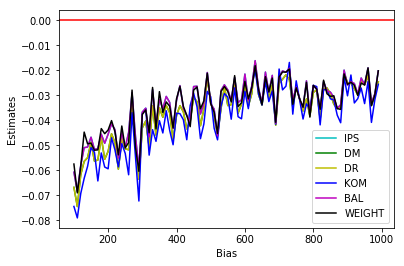

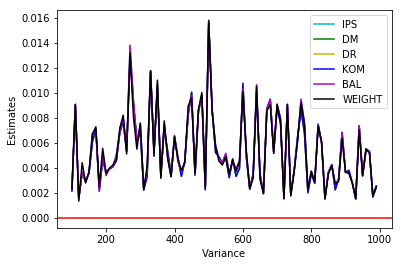

In [55]:
# Plot of Toy Example
plot2([2,4], [3,5], [3,5], 100, 1000, 10, 10)

# Simpler Problem (A Variant of Missing Data Problem)

Suppose we are given i.i.d. covariates $X_1, \ldots X_T$ and the corresponding partially observed i.i.d. outcomes $Y_1, \ldots Y_T$. Here, 
$$
Y_t = \begin{cases} Y_t^* &&C_t(X_t) = 1 \\ N/A && C_t(X_t) = 0\end{cases}
$$
and $C_t$ depends on the historical data $X_{1:(t-1)}, Y_{1:(t-1)}$. 



## Evaluating $\mathbb{E}[Y]$

1. Naive Estimator
$$
\frac{\sum_{t=1}^T \mathbb{I}(C_t(X_t)=1)Y_t}{\sum_{t=1}^T \mathbb{I}(C_t(X_t)=1)}
$$

2. Propensity Score from History
$$
\frac{1}{T} \sum_{t=1}^T \frac{\mathbb{I}(C_t(X_t)=1)Y_t}{\mathbb{P}(C_t(X_t) = 1 \mid X_{1:t})}
$$

3. History-free Propensity Score
$$
\frac{1}{T} \sum_{t=1}^T \frac{\mathbb{I}(C_t(X_t)=1)Y_t}{\mathbb{P}(C_t(X_t) = 1 \mid X_{t})}
$$

4. Averaging Propensity Score
$$
\frac{1}{T} \sum_{t=1}^T \frac{\mathbb{I}(C_t(X_t)=1)Y_t}{\frac{1}{T}\sum_{t'=1}^T\mathbb{P}(C_{t'}(X_t) = 1 \mid X_{t})}
$$

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
def generate_naive(T, eps = 1e-2):
    
    y = np.zeros(5)
    while np.sum(y) < 1 or np.prod(y) != 0: 
        X1 = LoggedDatum(5, [1,1])
        x = X1.x
        y = X1.y
        y_prob = []
    
    X = np.random.multivariate_normal(np.zeros(2), np.eye(2), T)
    prob = X1.p_matrix(X1.x, X1.pol_param)[:,1]

    for i in range(T):
        clf = LogisticRegression(solver = "lbfgs")
        clf.fit(x, y)
        y_pred = clf.predict(X[i].reshape(1, -1))
        y_prob.append(clf.predict_proba(X[i].reshape(1, -1))[0])
        if np.random.rand(1) > eps:
           x = np.vstack((x, X[i]))
           y = np.concatenate((y, y_pred))
        else:
           x = np.vstack((x, X[i]))
           y = np.concatenate((y, 1 - y_pred))  
            
    return x[5:], y[5:], np.concatenate((prob, np.array(y_prob)[:,1]))[5:]

In [0]:
def generate_ps(T, eps = 1e-2):
    
    y = np.zeros(5)
    while np.sum(y) < 1 or np.prod(y) != 0: 
        X1 = LoggedDatum(5, [1,1])
        x = X1.x
        y = X1.y
        
    X = np.random.multivariate_normal(np.zeros(2), np.eye(2), T)

    for i in range(T):
        clf = LogisticRegression(solver = "lbfgs")
        clf.fit(x, y)
        y_pred = clf.predict(X[i].reshape(1, -1))
        if np.random.rand(1) > eps:
           x = np.vstack((x, X[i]))
           y = np.concatenate((y, y_pred))
        else:
           x = np.vstack((x, X[i]))
           y = np.concatenate((y, 1 - y_pred))  
            
    return x[5:], y[5:]

In [0]:
def generate_aps(T, eps = 1e-2):
    
    y = np.zeros(5)
    while np.sum(y) < 1 or np.prod(y) != 0: 
        X1 = LoggedDatum(5, [1,1])
        x = X1.x
        y = X1.y
        
    X = np.random.multivariate_normal(np.zeros(2), np.eye(2), T)
    
    sum = np.zeros(T)
    for i in range(T):
        clf = LogisticRegression(solver = "lbfgs")
        clf.fit(x, y)
        y_pred = clf.predict(X)
        sum += y_pred
        if np.random.rand(1) > eps:
            x = np.vstack((x, X[i]))
            y = np.concatenate((y, [y_pred[i]]))
        else:
            x = np.vstack((x, X[i]))
            y = np.concatenate((y, [1 - y_pred[i]]))  
            
    return x[5:], y[5:], sum / T

In [0]:
x, y, y_prob = generate_naive(1000)

In [0]:
def naive(x, y):
    # Estimator 1
    a1_idx = np.where(y == 1)[0]
    return np.mean(r1(x[a1_idx]))

def ipsh(x, y, y_prob, T = 1000):
    # Estimator 2
    a1_idx = np.where(y == 1)[0]
    return 1 / T * np.sum(r1(x[a1_idx]) / y_prob[a1_idx])
    
def ipshf(x, y, iter, T = 1000):
    # Estimator 3
    a1_idx = np.where(y == 1)[0]
    summand = np.zeros(T)
    for i in range(iter):
        x, y = generate_ps(T)
        summand += y
    summand /= T
    
    return 1 / T * np.sum(r1(x[a1_idx]) / summand[a1_idx])
    
def aps(x, y, iter, T = 1000):
    # Estimator 4
    a1_idx = np.where(y == 1)[0]
    summand = np.zeros(T)
    for i in range(iter):
        x, y, s = generate_aps(T)
        summand += s
    summand /= T
    
    return 1 / T * np.sum(r1(x[a1_idx]) / summand[a1_idx])

In [111]:
naive(x, y) 

13.102463744750413

In [112]:
ipsh(x, y, y_prob)

13.21818303556195

In [113]:
ipshf(x, y, 100)

267.8604240613612

In [114]:
aps(x, y, 100)

268.4495868302245

# Playing with Real Data

In [74]:
!pip install pystruct

     |████████████████████████████████| 5.6MB 4.6MB/s 
     |████████████████████████████████| 675kB 28.9MB/s 
  Created wheel for pystruct: filename=pystruct-0.3.2-cp36-cp36m-linux_x86_64.whl size=5916945 sha256=767c45a8f83bdb40f1503ce68f4fa6ce126f75cd1327fde02b15bff73d8d85ef
  Stored in directory: /root/.cache/pip/wheels/d4/47/c8/18233d60780a14437cf42d8598ba553c0fefc832c0827c42fe
Successfully built pystruct


In [0]:
from pystruct.datasets import load_scene
from pystruct.learners import NSlackSSVM
from pystruct.models import MultiLabelClf

scene = load_scene()
X_train, X_test = scene['X_train'], scene['X_test']
y_train, y_test = scene['y_train'], scene['y_test']

class LoggedDatumMC():
    """
    =============================
    Matrix Version of LoggedDatum
    =============================
    """
    scene = load_scene()
#     global X_train, X_test, y_train, y_test
    X_train, X_test = scene['X_train'], scene['X_test']
    y_train, y_test = scene['y_train'], scene['y_test']
    model = MultiLabelClf()

    def __init__(self, n, pol_param = None, eps = 1e-12):
        self.n = n
        self.eps = eps

        rand_idx = np.random.choice(self.X_train.shape[0], n)
        self.x = self.X_train[rand_idx]
        self.y = self.y_train[rand_idx]
        self.num_labels = self.y.shape[1]

        if pol_param is None:
            clf = NSlackSSVM(self.model)
            clf.fit(self.x, self.y)
#             self.y_pred = clf.predict(self.X_train)
            self.pol_param = clf.w
        else: 
            self.pol_param = pol_param
            

        lst = np.array(list(map(list, itertools.product([0, 1], repeat = self.num_labels))))
        self.label_idx = np.where((lst == self.y[:, None]).all(-1))[1]
        self.d = self.d_matrix()[np.arange(len(self.y)), self.label_idx]
        self.p = self.p_matrix(self.pol_param)[np.arange(len(self.y)), self.label_idx]
            
    def pi(self, X, Y, param_new):
        '''
        Returns: 1-d array of pi(y | x)
        '''
        lst = np.array(list(map(list, itertools.product([0, 1], repeat = self.num_labels))))
        idx = np.where((lst == Y[:, None]).all(-1))[1]
        p = self.p_matrix(param_new)[np.arange(len(Y)), idx]
        return p
    
    def d_matrix(self):
        # All possible combinations of n binary values
        lst = np.array(list(map(list, itertools.product([0, 1], repeat = self.num_labels))))
        return np.array([np.sum(self.y_train[i] == lst, axis = 1) for i in range(len(self.y_train))])
        
    def crf_weight(self, X, Y):
        clf = NSlackSSVM(self.model)
        clf.fit(X, Y)
        clf.predict(self.X_train)
        return clf.w
    
    def pi_helper(self, x, pol_param):
        # All possible combinations of n binary values
        lst = np.array(list(map(list, itertools.product([0, 1], repeat = self.num_labels))))
        P = [np.exp(np.dot(pol_param, self.model.joint_feature(x, lst[i]))) for i in range(len(lst))]
        P_norm = P / np.sum(P)
        P_norm[P_norm < self.eps] = self.eps
        P_norm[P_norm > 1 - self.eps] = 1 - self.eps
        return P_norm
    
    def p_matrix(self, pol_param):
        return np.array([self.pi_helper(self.X_train[i], pol_param) for i in range(len(self.X_train))])

    # Estimators       
    def u_mc(self, param_new):
        p_new = self.p_matrix(param_new)[self.label_idx]
        d_new = self.d_matrix()[self.label_idx]
        return np.sum(d_new * p_new) / self.n
        
    def u_ips(self, param_new):
        return np.mean(self.d * self.pi(self.x, self.y, param_new) / self.p)

In [95]:
# Toy Example with sample size 100
test = LoggedDatumMC(100)

print("Sample Average Policy Effect:", test.u_mc(test.pol_param))
print("IPS Estimator:", test.u_ips(test.pol_param))

Sample Average Policy Effect: 3.7435369581560236
IPS Estimator: 4.09


In [0]:
class LoggedDataMC():
    """
    ============================
    Matrix Version of LoggedData
    ============================
    """
    

    def __init__(self, *args):
        self.data = args
        self.num_logs = np.array(list(map(lambda dt: dt.n, args)))
        self.N = len(X_train)
        self.X = list(map(lambda dt: dt.x, args))
        self.Y = list(map(lambda dt: dt.y, args))
        self.D = np.array(list(map(lambda dt: dt.d, args)))
        self.P = np.array(list(map(lambda dt: dt.p, args)))
        self.pol_params = np.array(list(map(lambda dt: dt.pol_param, args)))
        self.P_matrix = np.array(list(map(lambda dt: dt.p_matrix(dt.pol_param), args)))
        self.D_matrix = np.array(list(map(lambda dt: dt.d_matrix(), args)))

        
    def pi_bar(self, param_new):
        return np.array(list(map(lambda dt: dt.pi(dt.x, dt.y, param_new), self.data)))
    
    def pi_bar_matrix(self, param_new):
        return np.array(list(map(lambda dt: dt.p_matrix(param_new), self.data)))
    
    # Expected Utility
    def utility_avg(self):
        return 1 / self.N * np.sum(self.P_matrix[0] * self.D_matrix[0])

    def u_helper(self, param_new):
        return self.D_matrix[0] * self.pi_bar_matrix(param_new)[0]
    
    def u_mc(self, param_new):
        '''
        '''        
#         return 1 / self.N * np.sum(np.concatenate(self.pi_bar_matrix(param_new) * self.D_matrix))
        return 1 / self.N * np.sum(self.u_helper(param_new))

    def u_ips(self, param_new):
        '''
        '''
        return 1 / self.N * np.sum(np.concatenate(self.D * self.pi_bar(param_new) / self.P))
    
    def pi_avg(self):
        '''
        '''
        w = self.num_logs / np.sum(self.num_logs)
        P_avg = [list(map(lambda dt: dt.pi(self.X[i], self.Y[i], dt.pol_param), self.data)) for i in range(len(self.X))]
        return np.array(list(map(lambda p: np.average(p, axis = 0, weights = w), P_avg)))
    
    def pi_avg_matrix(self):
        '''
        '''
        w = self.num_logs / np.sum(self.num_logs)
        P_avg = [list(map(lambda dt: dt.p_matrix(dt.pol_param), self.data)) for i in range(len(self.X))]
        return np.array(list(map(lambda p: np.average(p, axis = 0, weights = w), P_avg)))
    
    def u_bal(self, param_new):
        '''
        '''
        return 1 / self.N * np.sum(np.concatenate(self.D * self.pi_bar(param_new) / self.pi_avg()))
    
    def div(self, param_new):
        '''
        Returns: divergence list of new policy w.r.t given logged data
        '''
        div_list = list(map(np.sum, np.power(self.u_helper(param_new), 2) / self.P_matrix))
        return 1 / self.N * np.array(div_list) - self.u_mc(param_new) ** 2 

    def div_emp(self, param_new):
        return np.array([np.var(arg.d * arg.pi(arg.x, arg.y, param_new) / arg.p) for arg in self.data])
    
    def u_weight(self, param_new):
        '''
        '''
        summand = 1 / self.v_weight_emp(param_new)
        lmbda_list = 1 / (self.div_emp(param_new) * summand)
        return np.sum(np.concatenate(lmbda_list * (self.D * self.pi_bar(param_new) / self.P)))
    
    # TODO: Variance (Needs Revision)
    def v_naive(self, param_new):
        return 1 / (self.N ** 2) * np.sum(self.num_logs * self.div(param_new))
    
    def v_bal(self, param_new):
        summand1 = list(map(np.sum, np.power(self.u_helper(param_new) / self.pi_avg_matrix(), 2) * self.P_matrix))
        summand2 = list(map(np.sum, self.u_helper(param_new) / self.pi_avg_matrix() * self.P_matrix))
#         return 1 / (self.N ** 2) * np.sum(self.num_logs * (np.array(summand1) / self.num_logs - np.power(np.array(summand2)/self.num_logs, 2)))
        return 1 / (self.N ** 2) * np.sum(self.num_logs * (1 / self.N * np.array(summand1) - np.power(1 / self.N * np.array(summand2), 2)))

    def v_weight_emp(self, param_new):
        summand = np.sum(self.num_logs / self.div_emp(param_new))
        return 1 / summand
    

In [100]:
# Toy Example with two data samples
test1 = LoggedDatumMC(10)
test2 = LoggedDatumMC(20)
T = LoggedDataMC(test, test2)

print("Sample Average Policy Effect:", T.u_mc(test1.pol_param))
print("IPS Estimator:", T.u_ips(test1.pol_param))
print("Balanced IPS Estimator:", T.u_bal(test1.pol_param))
print("Weighted IPS Estimator:", T.u_weight(test1.pol_param))

Sample Average Policy Effect: 3.803070343236047
IPS Estimator: 1.224103443692762
Balanced IPS Estimator: 0.7473778933292553
Weighted IPS Estimator: 7.038434658268041
